In [359]:
#explore the data 
import sys
import numpy as np 
import matplotlib.pylab as plt
#import seaborn as sns
import pandas as pd 
import datetime as datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

import folium
from folium import plugins

from datetime import timedelta

sys.path.insert(0, "../apps/") # add the path to python so we have relaitve imports
import geo_func as gf
#sys.path.insert(0, "../chicago_neighborhood_finder/") # add the path to python so we have relaitve imports

In [324]:
train = pd.read_csv("../data/train.csv",header=0)
weather = pd.read_csv("../data/weather.csv",header=0)
spray = pd.read_csv("../data/spray.csv")
train.columns

Index([u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')

In [249]:
train.head(n=1)
print 'There are {} samples to work with in the training '.format(len(train))
print 'There are {} samples of wnv '.format(len(train[train.WnvPresent==1]))
print 'There are {} samples to Not WNV'.format(len(train[train.WnvPresent==0]))
# All thew good overlap ocourse when we are at 2011 and 2013 
# so let's use this for training since we probably plenty stats just for this example. 

train['Date']= pd.to_datetime(train['Date'], format='%Y-%m-%d')
train["year"] = train['Date'].dt.year
train["month"] = train['Date'].dt.month 

#make date into a datetime
weather['Date']= pd.to_datetime(weather['Date'], format='%Y-%m-%d')
weather["year"] = weather['Date'].dt.year

# replace precip missing values and T with 0
weather["PrecipTotal"] = weather["PrecipTotal"].replace('M', 0.0)
weather["PrecipTotal"] = weather["PrecipTotal"].replace('  T', 0.0)
weather["PrecipTotal"] = weather["PrecipTotal"].replace('T', 0.0)
weather["PrecipTotal"] = weather["PrecipTotal"].replace(' T', 0.0)
weather["PrecipTotal"] =weather.PrecipTotal.astype('float64')

#temp
weather["Tavg"] = weather["Tavg"].replace('M',-999.)
weather["Tavg"] =weather.Tavg.astype('float64')
weather["Tmin"] = weather["Tmin"].replace('M',-999.)
weather["Tmin"] =weather.Tmin.astype('float64')
weather["Tmax"] = weather["Tmax"].replace('M',-999.)
weather["Tmax"] =weather.Tmax.astype('float64')

weather["AvgSpeed"] = weather["AvgSpeed"].replace('M',-999.)
weather["AvgSpeed"] = weather.AvgSpeed.astype("float64")
weather["StnPressure"] = weather["StnPressure"].replace('M',-999.)
weather["StnPressure"] = weather.StnPressure.astype("float64")

mydf = train[(train.year==2011) | (train.year==2013)]

#make closest station to trap
trapname_station ={}
for name, group in mydf.groupby('Trap'):
    #trapname_list.append(name)
    testlat = group[0:1].Latitude.values
    testlon = group[0:1].Longitude.values
    close_stat = gf.closest_station_id(testlat,testlon)
    trapname_station.update({name: close_stat})
    
def make_close_col(row,mydict):
    return trapname_station[row.Trap]
    
mydf['Closest_Station'] = mydf.apply(lambda row: make_close_col(row,trapname_station), axis=1)   

There are 10506 samples to work with in the training 
There are 551 samples of wnv 
There are 9955 samples to Not WNV


In [251]:
def make_Xday_precip_sum(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["PrecipTotal"].values
    return sum(retval)

def make_Xday_precip_avg(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["PrecipTotal"].values
    return np.mean(retval)

def make_Xday_temp_avg(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    
    retval = tempdf["Tavg"].values
    if -999 in retval:
        retval = [ x for x in retval if x !=-999]
    return np.mean(retval)
       
def make_Xday_temp_low(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["Tmin"].values
    return min(retval)

def make_Xday_temp_hi(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["Tmax"].values
    return max(retval)

def make_Xday_wind_avg(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["AvgSpeed"].values
    if -999 in retval:
        retval = [ x for x in retval if x !=-999]
    return max(retval)
def make_Xday_pressure_avg(row,wdf,d):
    #get the date
    Thedate = row.Date
    pdate = Thedate - timedelta(days=d)
    tempdf = wdf[(wdf.Date>=pdate) & (wdf.Date<Thedate) & (wdf.Station ==row.Closest_Station)] 
    retval = tempdf["StnPressure"].values
    if -999 in retval:
        retval = [ x for x in retval if x !=-999]
    return max(retval)


mydf['meanprecip_1'] = mydf.apply(lambda row: make_Xday_precip_avg(row,weather,1), axis=1) 
mydf['sumprecip_1'] = mydf.apply(lambda row: make_Xday_precip_sum(row,weather,1), axis=1) 
mydf['Tavg_1'] = mydf.apply(lambda row: make_Xday_temp_avg(row,weather,1), axis=1)    
mydf['Tlo_1'] = mydf.apply(lambda row: make_Xday_temp_low(row,weather,1), axis=1) 
mydf['Thi_1'] = mydf.apply(lambda row: make_Xday_temp_hi(row,weather,1), axis=1) 
mydf['Windavg_{}'.format(i)] = mydf.apply(lambda row: make_Xday_wind_avg(row,weather,i), axis=1) 
mydf['pressureavg_{}'.format(i)] = mydf.apply(lambda row: make_Xday_pressure_avg(row,weather,i), axis=1) 

for i in range(5,25,5):
    print i
    mydf['meanprecip_{}'.format(i)] = mydf.apply(lambda row: make_Xday_precip_avg(row,weather,i), axis=1) 
    mydf['sumprecip_{}'.format(i)] = mydf.apply(lambda row: make_Xday_precip_sum(row,weather,i), axis=1) 
    mydf['Tavg_{}'.format(i)] = mydf.apply(lambda row: make_Xday_temp_avg(row,weather,i), axis=1)    
    mydf['Tlo_{}'.format(i)] = mydf.apply(lambda row: make_Xday_temp_low(row,weather,i), axis=1) 
    mydf['Thi_{}'.format(i)] = mydf.apply(lambda row: make_Xday_temp_hi(row,weather,i), axis=1) 
    mydf['Windavg_{}'.format(i)] = mydf.apply(lambda row: make_Xday_wind_avg(row,weather,i), axis=1) 
    mydf['pressureavg_{}'.format(i)] = mydf.apply(lambda row: make_Xday_pressure_avg(row,weather,i), axis=1) 

/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

5


/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

10
15
20


In [257]:
mydf_1 = mydf.copy()
mydf_1 = mydf_1.drop(['Address','Block','Street',"AddressNumberAndStreet"],axis=1)
print mydf_1.columns

Index([u'Date', u'Species', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'year', u'month',
       u'Closest_Station', u'meanprecip_1', u'sumprecip_1', u'Tavg_1',
       u'Tlo_1', u'Thi_1', u'Windavg_20', u'pressureavg_20', u'meanprecip_5',
       u'sumprecip_5', u'Tavg_5', u'Tlo_5', u'Thi_5', u'Windavg_5',
       u'pressureavg_5', u'meanprecip_10', u'sumprecip_10', u'Tavg_10',
       u'Tlo_10', u'Thi_10', u'Windavg_10', u'pressureavg_10',
       u'meanprecip_15', u'sumprecip_15', u'Tavg_15', u'Tlo_15', u'Thi_15',
       u'Windavg_15', u'pressureavg_15', u'meanprecip_20', u'sumprecip_20',
       u'Tavg_20', u'Tlo_20', u'Thi_20'],
      dtype='object')


# Which West Nile Species 
Is one species more prone to being WNV ? 
If so, them we want to find if there are any hotspots for where this species lives in chicago?


There are 7 different Species types 


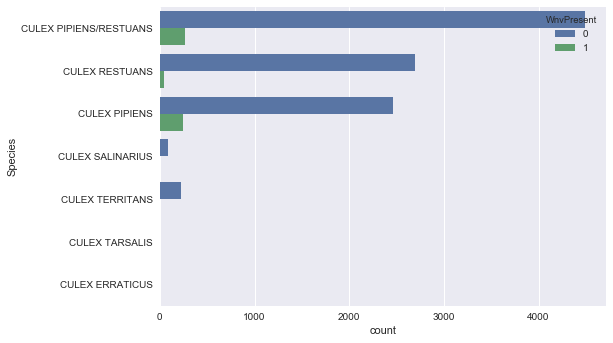

In [340]:
#print train.columns
print 'There are {} different Species types '.format(len(train.groupby("Species")))
def make_count():
    import seaborn as sns
    # Look at the ones that contain WNV
    sns.countplot(y="Species", data=train,hue="WnvPresent")
    plt.show()
make_count()

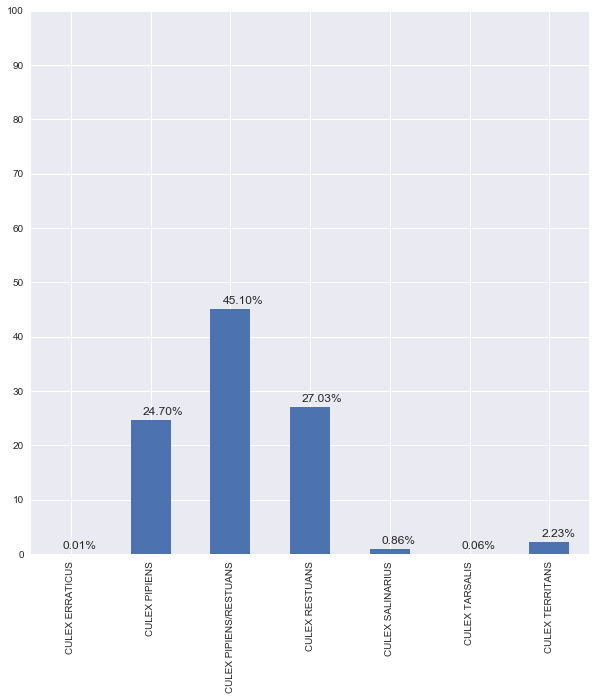

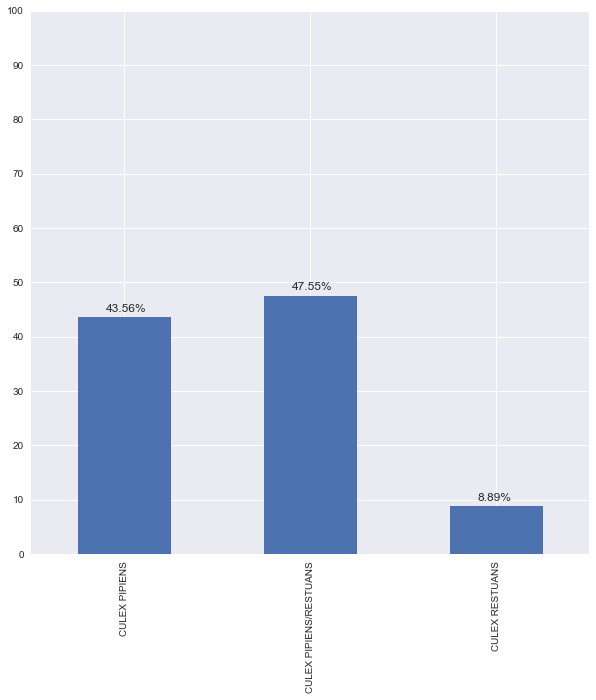

In [260]:
#Look a little closer 

plt.figure(figsize=(10,10))
ax = (train[train.WnvPresent==0].Species.value_counts()/len(train[train.WnvPresent==0])*100).sort_index().plot(kind="bar", rot=90)
ax.set_yticks(np.arange(0, 110, 10))
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()

plt.figure(figsize=(10,10))
wax = (train[train.WnvPresent==1].Species.value_counts()/len(train[train.WnvPresent==1])*100).sort_index().plot(kind="bar", rot=90)
wax.set_yticks(np.arange(0, 110, 10))
for p in wax.patches:
    wax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

plt.show()

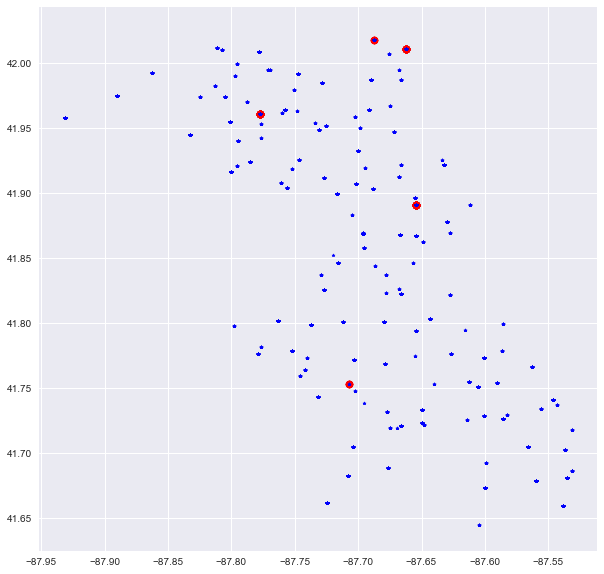

In [279]:
# Some types don't have WNV
nownv_bytype = train[(train.Species!='CULEX PIPIENS')& (train.Species!='CULEX PIPIENS/RESTUANS') &(train.Species!='CULEX RESTUANS')]
#len(nownv_bytype)

# are there any testing sites that have only this speciese
noWNV_bytype_trap =[] # list of names of traps that have the wnv free type
for name, group in nownv_bytype.groupby("Trap"):
    noWNV_bytype_trap.append(name)

solo_noWNV_bytype_trap =[]
match_hasWNV = []
for name, group in train.groupby("Trap"):# loop over everything just to see
    if name in noWNV_bytype_trap:
        # Now loop over the Species and see if there are any that are WNV
        WNV_Free = True
        for g in group.WnvPresent.values: 
            if g==1:
                # Has WNV and is not a free trap 
                match_hasWNV.append(name)
                WNV_Free=False
        if WNV_Free:
            solo_noWNV_bytype_trap.append(name)

#Get rid of the ones that only have a certain type of virus
mydf_2 = mydf_1[mydf_1.Trap.isin(match_hasWNV)]

#WHERE ARE NO WNV
nownv = mydf_1[mydf_1.Trap.isin(solo_noWNV_bytype_trap)]

plt.figure(figsize=(10,10))
plt.scatter(nownv.Longitude,nownv.Latitude,s=50,color='red')
plt.scatter(train.Longitude,train.Latitude,s=10,marker='*',color='blue')

plt.show()

# Features 


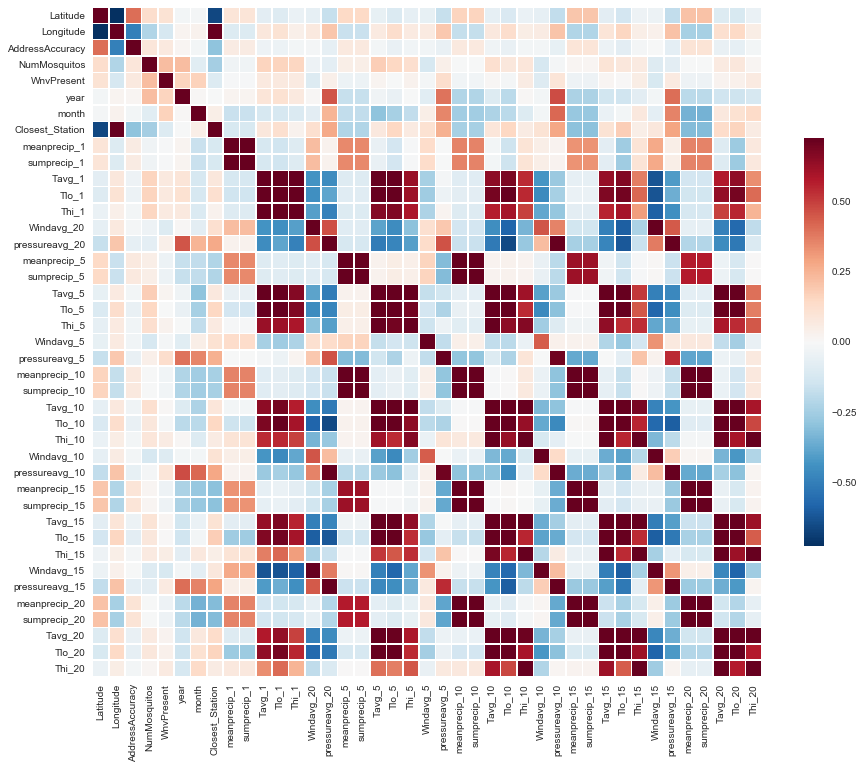

In [280]:
#correlation matrix 
mycorr = mydf_2.corr()

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(mycorr, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

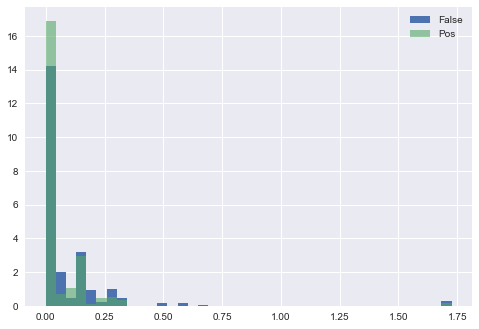

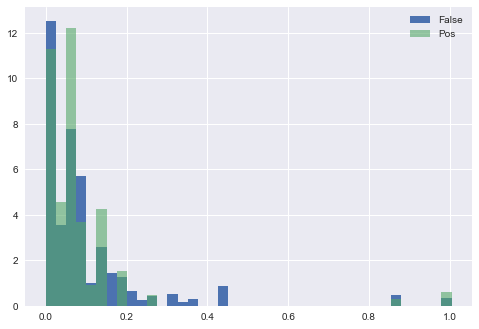

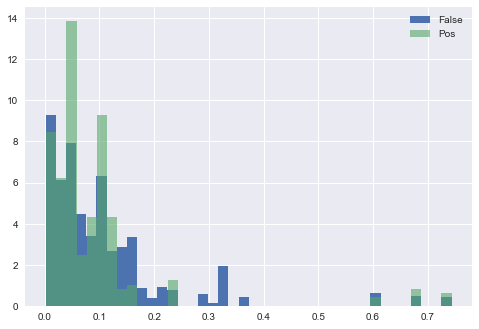

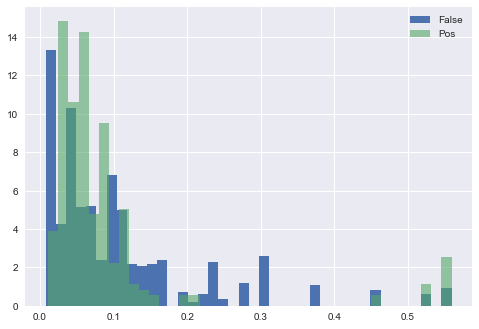

In [281]:
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].meanprecip_5, bins=40,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].meanprecip_5, bins=40, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].meanprecip_10, bins=40,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].meanprecip_10, bins=40, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].meanprecip_15, bins=40,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].meanprecip_15, bins=40, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].meanprecip_20, bins=40,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].meanprecip_20, bins=40, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

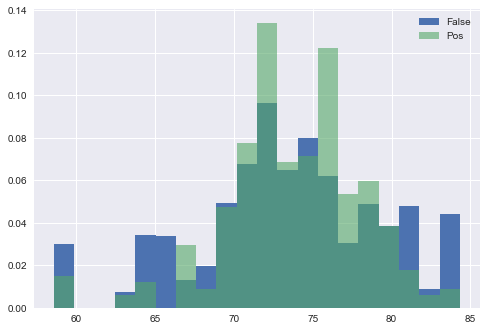

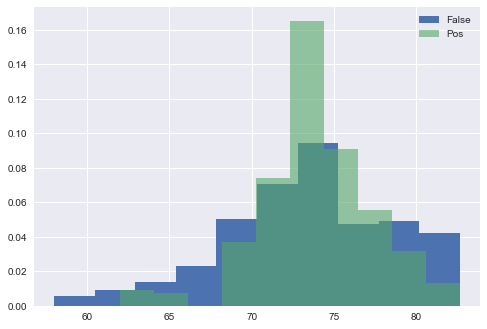

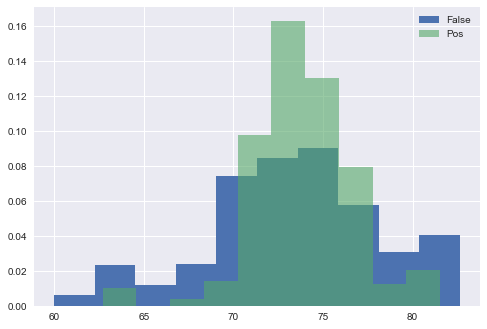

In [286]:
#x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Tavg_5, bins=20,normed=True,label='False')
#x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Tavg_5, bins=20, alpha=0.6,normed=True,label='Pos')
#plt.legend()
#plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Tavg_10, bins=20,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Tavg_10, bins=20, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Tavg_15, bins=10,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Tavg_15, bins=10, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Tavg_20, bins=10,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Tavg_20, bins=10, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.show()


# Start making a model
Run the next cell functions and move on

In [303]:
### This cell has funcitons move on after you execute 

#Brute Force it a little
def make_model(myestimator,mygrid,myX, myy):
    '''
    input: the estimator, the dict for the grid search, the X features, the pred Y
    return: a model that is best fit from the given grid search
    '''
    CV_rfc = GridSearchCV(estimator=myestimator, param_grid=mygrid,cv=10,n_jobs=1,verbose=2)
    #CV_rfc = GridSearchCV(estimator=myestimator, param_grid=mygrid,cv=10,n_jobs=1,scoring='precision',verbose=2)
    CV_rfc.fit(myX, myy) 
    pv = CV_rfc.best_params_
    print pv
    return CV_rfc

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    """
    """
    from sklearn.model_selection import learning_curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R2_Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    
def make_feat_imp(myreg,mydf,top=0,dep=15):
    # Get Feature Importance from the classifier
    feature_importance = myreg.feature_importances_
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(16, 12))
    dep = len(pos)-dep
    top = len(pos)-top
    plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top],align='center', color='r')
    plt.yticks(pos[dep:top], np.asanyarray(mydf.columns.tolist())[sorted_idx][dep:top])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()


We know we have an unbalanced dataset. We already have made features, some of which contain catagorical data. To get a first pass I am going to use a tree classifier 

* Try underampling (will be hard) 
* Try oversampling/bootstraps 

To start I am going to optimize on accuracy. Later we can think to optimize on Recal since we want to catch as many of the WNV cases as possible 

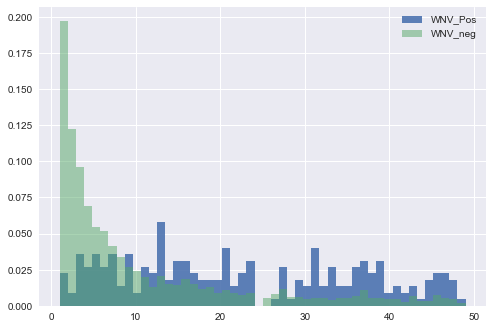

3471
261


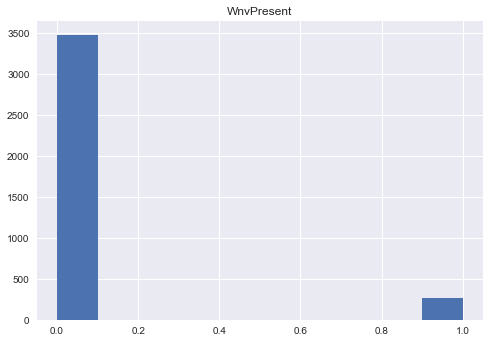

In [388]:
# What do we have to work with?
plt.hist(mydf_2[(mydf_2.WnvPresent==1) & (mydf_2.NumMosquitos<50)].NumMosquitos,bins=50,normed=True,alpha=0.9,label='WNV_Pos')
plt.hist(mydf_2[(mydf_2.WnvPresent==0) & (mydf_2.NumMosquitos<50)].NumMosquitos,bins=50,normed=True,alpha =0.5,label='WNV_neg')
plt.legend()
plt.show()

print len(mydf_2[mydf_2.WnvPresent==0])
print len(mydf_2[mydf_2.WnvPresent==1])
mydf_2.hist('WnvPresent')
plt.show()

## DownSampling

In [405]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# Drop out some more things for the model df 
model_df = mydf_2.copy()

# remeber features are things we can't know by looking up. 
# This means that we can't look at the trap to see how many mosquitoes are in it.
model_df=model_df.drop("Latitude",axis=1)
model_df=model_df.drop("Longitude",axis=1)
model_df=model_df.drop("AddressAccuracy",axis=1)
model_df=model_df.drop("NumMosquitos",axis=1)
model_df=model_df.drop("Closest_Station",axis=1)
model_df=model_df.drop("Species",axis=1)
model_df=model_df.drop("Date",axis=1)
model_df=model_df.drop("year",axis=1)

model_df = pd.get_dummies(model_df, columns=['Trap',"month"])
model_feat = model_df.drop('WnvPresent',axis=1)
model_pred = model_df["WnvPresent"]
#print model_df.columns

#LETS TRY TO DOWN SAMPLE 
# We have a class imbalance. 
# Lets get some balanced datasets
rus = RandomUnderSampler(random_state=42)

X_downsampled, y_downsampled = rus.fit_sample(model_feat,model_pred)
#print X_downsampled
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)
print ' we are left with {}'.format(len(X_downsampled))
# not a lot to work with 

 we are left with 522


In [292]:
# Now we will try a quick RF regression since we have lots of catagory data and we also have some linear data

# Random Grid search to improve params in the RF 
rf_est = RandomForestClassifier()
rf_grid ={
    "n_estimators": [500,800,1200],
    "max_depth": [4,8,10],
    "max_features": [83]
    }

my_rf =make_model(rf_est,rf_grid,X_train,y_train)
#my_rf = RandomForestClassifier(max_features=83,n_estimators=1200,max_depth=8)# From second Grid Search
#{'max_depth': 8, 'max_features': 83, 'n_estimators': 800}
my_rf.fit(X_train,y_train)
my_rf.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.4s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.0min finished


{'max_features': 83, 'n_estimators': 800, 'max_depth': 8}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.4s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.4s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.4s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] ... max_features=83, n_estimators=500, max_depth=4, total=   1.3s
[CV] max_features=83, n_estimators=500, max_depth=4 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.0min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 800, 1200], 'max_features': [83], 'max_depth': [4, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

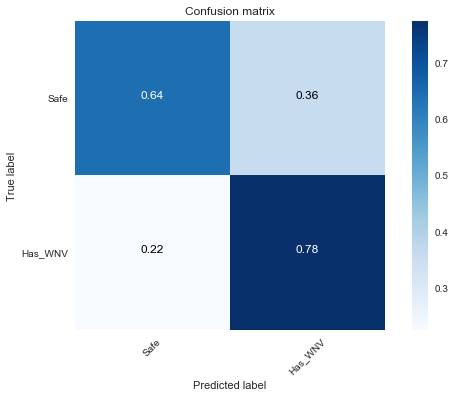

In [302]:
y_pred = my_rf.predict(X_test)
#print confusion_matrix(y_test, y_pred)
    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),['Safe', 'Has_WNV'], normalize=True)
plt.grid(False)
plt.show()

[learning_curve] Training set sizes: [ 41 116 191 266 341 417]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


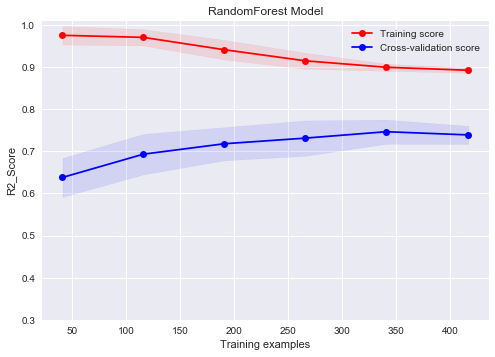

In [298]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(my_rf.best_estimator_, 'RandomForest Model',X_downsampled, y_downsampled, ylim=(0.3, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

{'max_features': 83, 'n_estimators': 800, 'max_depth': 8}


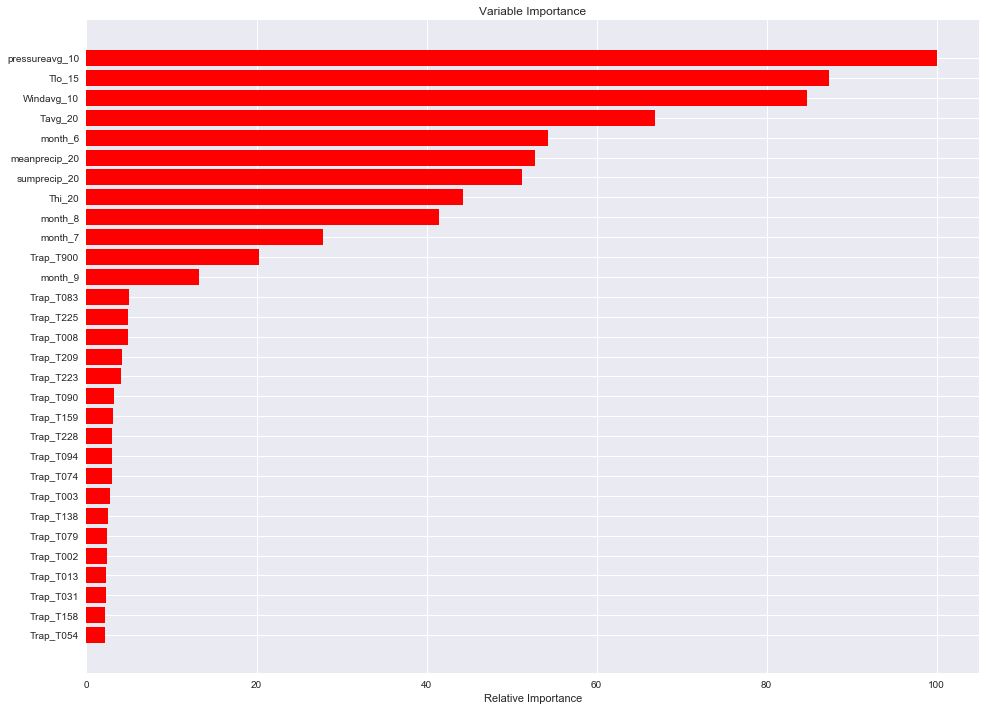

In [389]:
temp_model = RandomForestClassifier(n_estimators=800,max_depth=8)
print my_rf.best_params_
temp_model.fit(X_train,y_train)
make_feat_imp(temp_model,model_feat,top=0,dep=30)
plt.show()

## Upsampling 

In [394]:
######
#from sklearn.utils import resample

#X_downsampled, y_downsampled = rus.fit_sample(model_feat,model_pred)
# Separate majority and minority classes
df_majority = model_df[model_df.WnvPresent==0]
df_minority = model_df[model_df.WnvPresent==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3471,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

1    3471
0    3471
Name: WnvPresent, dtype: int64

In [395]:
model_feat = df_upsampled.drop('WnvPresent',axis=1)
model_pred = df_upsampled["WnvPresent"]
#print len(model_df.columns)
#print model_feat.columns
X_train, X_test, y_train, y_test = train_test_split(model_feat,model_pred, test_size=0.2, random_state=42)

In [396]:
rf_est = RandomForestClassifier()
rf_grid ={
    "n_estimators": [500,800,1200],
    "max_depth": [4,8,10],
    "max_features": [83]
    }

#my_rf_up =make_model(rf_est,rf_grid,X_train,y_train)
my_rf_up = RandomForestClassifier(max_features=83,n_estimators=500,max_depth=10)# From second Grid Search
#{'max_features': 83, 'n_estimators': 500, 'max_depth': 10}
my_rf_up.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=83, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

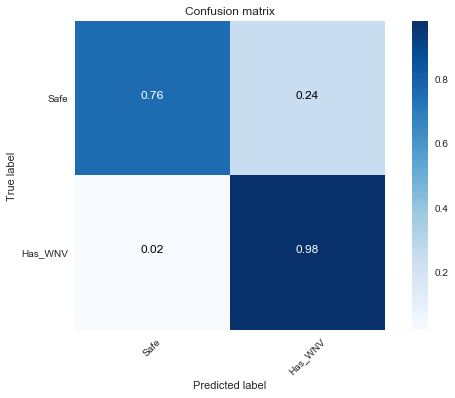

In [398]:
y_pred_up = my_rf_up.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_up),['Safe', 'Has_WNV'], normalize=True)
plt.grid(False)
plt.show()

[learning_curve] Training set sizes: [ 555 1554 2554 3553 4553 5553]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.7min finished


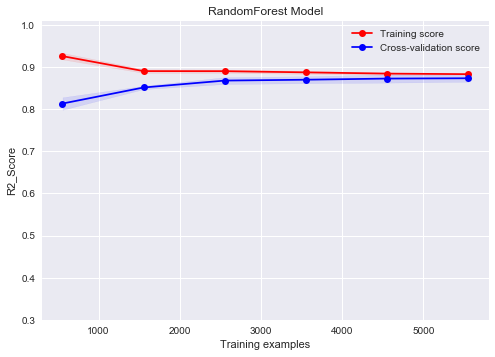

In [400]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(my_rf_up, 'RandomForest Model',model_feat,model_pred, ylim=(0.3, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

## Cherry_Picked Model

### Oversampling again

In [406]:
########## Grab special features 

base_feat = ['pressureavg_10','Windavg_10',"Tlo_15",'Tavg_20','meanprecip_20',"sumprecip_20","Thi_20",'month','Trap',"WnvPresent"]

model_df = mydf_2.copy()
# remeber features are things we can't know upon looking
model_df=model_df.drop("Latitude",axis=1)
model_df=model_df.drop("Longitude",axis=1)
model_df=model_df.drop("AddressAccuracy",axis=1)
model_df=model_df.drop("NumMosquitos",axis=1)
model_df=model_df.drop("Closest_Station",axis=1)
model_df=model_df.drop("Species",axis=1)
model_df=model_df.drop("Date",axis=1)
model_df=model_df.drop("year",axis=1)
model_df = model_df[base_feat]
model_df = pd.get_dummies(model_df, columns=['Trap',"month"])
model_feat = model_df.drop('WnvPresent',axis=1)
model_pred = model_df["WnvPresent"]

In [407]:
# Over sample again

# Separate majority and minority classes
df_majority = model_df[model_df.WnvPresent==0]
df_minority = model_df[model_df.WnvPresent==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3471,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

model_feat = df_upsampled.drop('WnvPresent',axis=1)
model_pred = df_upsampled["WnvPresent"]

X_train, X_test, y_train, y_test = train_test_split(model_feat,model_pred, test_size=0.2, random_state=42)

In [408]:
#rf_est = RandomForestClassifier()
rf_grid ={
    "n_estimators": [500,800,1200],
    "max_depth": [4,8,10],
    "max_features": [72]
    }

#my_rf_cherry =make_model(rf_est,rf_grid,X_train,y_train)
my_rf_cherry = RandomForestClassifier(max_features=72,n_estimators=800,max_depth=10)# From second Grid Search
#{'max_features': 72, 'n_estimators': 800, 'max_depth': 10}
my_rf_cherry.fit(X_train,y_train)
#my_rf.best_params_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=72, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

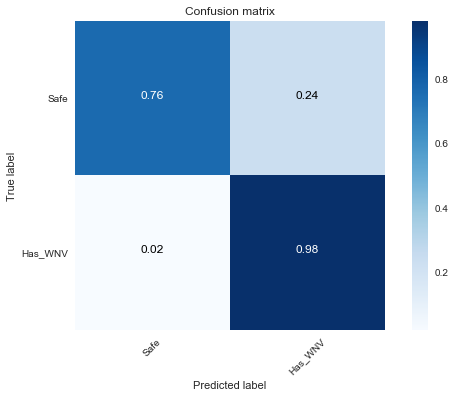

In [411]:
y_pred_cherry = my_rf_cherry.predict(X_test)
#print my_rf_cherry.best_params_
plot_confusion_matrix(confusion_matrix(y_test, y_pred_cherry),['Safe', 'Has_WNV'], normalize=True)
plt.grid(False)
plt.show()

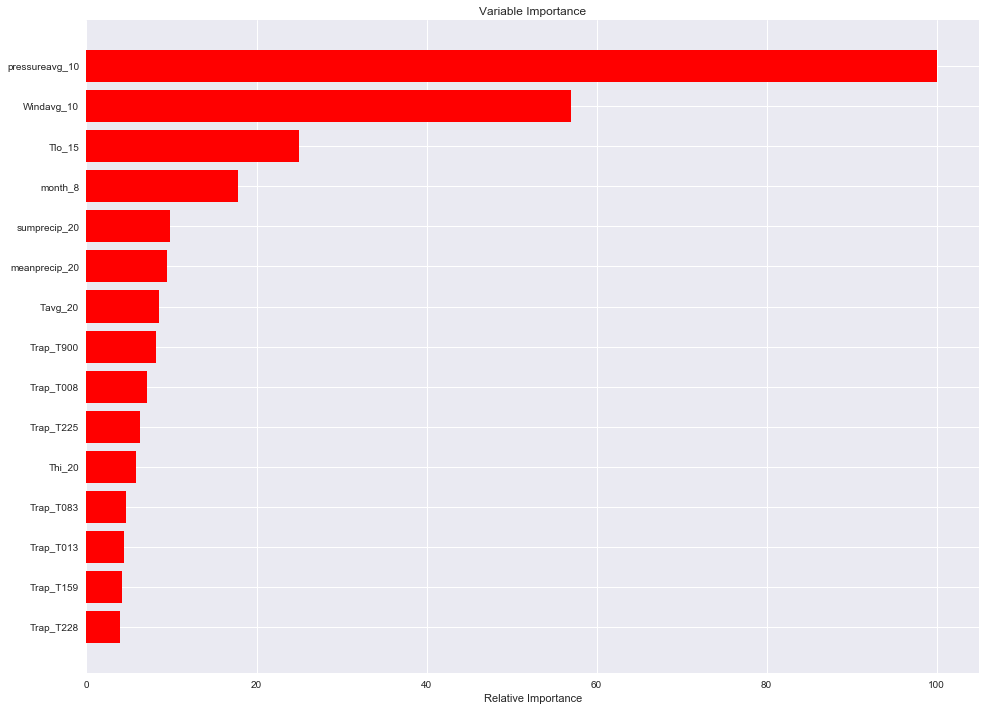

In [412]:
#temp_model = RandomForestClassifier(n_estimators=1200,max_depth=8)
#print my_rf.best_params_
#temp_model.fit(X_train,y_train)
make_feat_imp(my_rf_cherry,model_feat,top=0,dep=15)
plt.show()

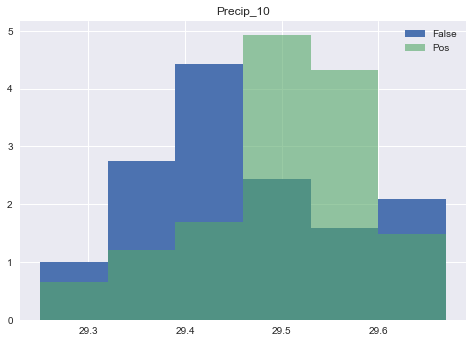

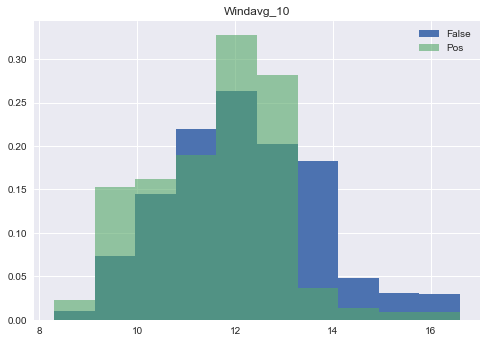

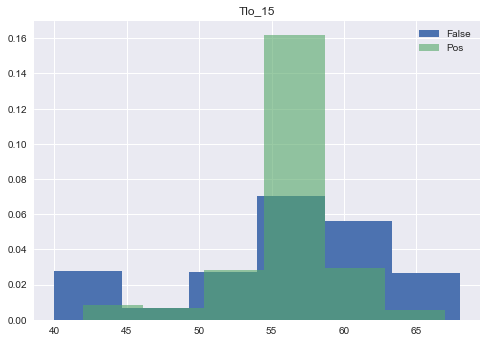

In [420]:
########### Last shows
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].pressureavg_10, bins=6,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].pressureavg_10, bins=6, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.title("Precip_10")
plt.show()


x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Windavg_10, bins=10,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Windavg_10, bins=10, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.title("Windavg_10")
plt.show()

x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==0].Tlo_15, bins=6,normed=True,label='False')
x,bins , p =plt.hist(mydf_2[mydf_2.WnvPresent==1].Tlo_15, bins=6, alpha=0.6,normed=True,label='Pos')
plt.legend()
plt.title("Tlo_15")
plt.show()



[learning_curve] Training set sizes: [ 555 1554 2554 3553 4553 5553]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.0min finished


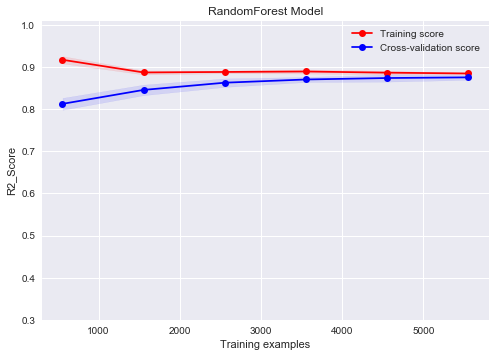

In [336]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(my_rf_cherry, 'RandomForest Model',model_feat,model_pred, ylim=(0.3, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

In [357]:
spray['Date'] = pd.to_datetime(spray['Date'])
spray['year']  = spray['Date'].dt.year
my_spray = spray[(spray.year==2011) | (spray.year==2013)]
print len(my_spray)
my_spray.dtypes

14835


Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
year                  int64
dtype: object

In [362]:
spray_heatmap = folium.Map(location=[train['Latitude'].mean(), train['Longitude'].mean()], zoom_start=10)
spray_heatmap.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in spray.iterrows()]))
spray_heatmap.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/spray_heatmap.html")

spray_heatmap

spray_heatmap11 = folium.Map(location=[train['Latitude'].mean(), train['Longitude'].mean()], zoom_start=10)
spray_heatmap11.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in spray[spray.year==2011].iterrows()]))
spray_heatmap11.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/spray11_heatmap.html")

spray_heatmap11


spray_heatmap13 = folium.Map(location=[train['Latitude'].mean(), train['Longitude'].mean()], zoom_start=10)
spray_heatmap13.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in spray[spray.year==2013].iterrows()]))
spray_heatmap13.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/spray13_heatmap.html")

spray_heatmap13


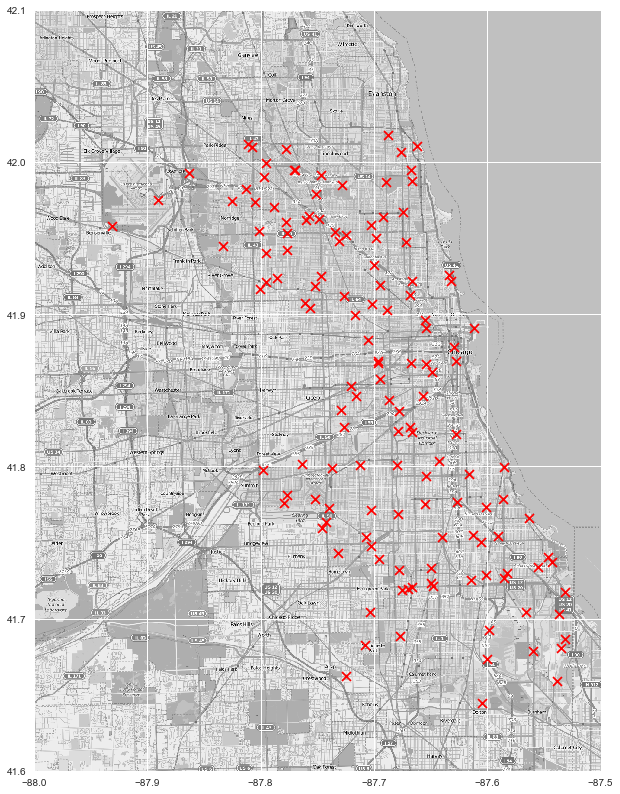

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline # Remove this when copying to a script on Kaggle:

mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(30,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x',s=80,color='red')
plt.show()

In [374]:
import folium
from folium import plugins

wnv_heatmap = folium.Map(location=[train['Latitude'].mean(), train['Longitude'].mean()], zoom_start=10)
wnv_heatmap.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in train[train.WnvPresent==1].iterrows()]))
wnv_heatmap.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/wnv_heatmap.html")

wnv_heatmap

# Crap hack 
train.dtypes
hack_train = train.copy()
hack_train['Date'] = pd.to_datetime(hack_train["Date"])
hack_train['year'] = hack_train['Date'].dt.year

wnv11_heatmap = folium.Map(location=[hack_train['Latitude'].mean(), hack_train['Longitude'].mean()], zoom_start=10)
wnv11_heatmap.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in hack_train[(hack_train.WnvPresent==1)& (hack_train.year==2011)].iterrows()]))
wnv11_heatmap.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/wnv11_heatmap.html")

wnv11_heatmap

wnv13_heatmap = folium.Map(location=[hack_train['Latitude'].mean(), hack_train['Longitude'].mean()], zoom_start=10)
wnv13_heatmap.add_children(plugins.HeatMap([[row["Latitude"], row["Longitude"]] for name, row in hack_train[(hack_train.WnvPresent==1)& (hack_train.year==2013)].iterrows()]))
wnv13_heatmap.save("/Users/ryangrosso/Data_Science/SparkChallenge/run/wnv13_heatmap.html")

wnv13_heatmap


In [15]:
mydf.columns

Index([u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'year'],
      dtype='object')

In [31]:
# Weather data comes from midway and ORD.... they are actually pretty close to eachother 
# some of the farthest south is at dolton/calumet city... that's really not that far from ORD 
# We may be able to use data 

station_1 = weather[weather['Station']==1]
station_2 = weather[weather['Station']==2]




trapname_station ={}

for name, group in mydf.groupby('Trap'):
    #trapname_list.append(name)
    testlat = group[0:1].Latitude.values
    testlon = group[0:1].Longitude.values
    close_stat = gf.closest_station_id(testlat,testlon)
    trapname_station.update({name: close_stat})

    #print gf.closest_station_id(group[0:1].Latitude,group[0:].Longitude)
    
print trapname_list
print trapname_station



['T002', 'T003', 'T008', 'T009', 'T011', 'T012', 'T013', 'T017', 'T018', 'T027', 'T028', 'T030', 'T031', 'T033', 'T035', 'T039', 'T043', 'T046', 'T047', 'T048', 'T049', 'T054', 'T054C', 'T061', 'T062', 'T063', 'T065', 'T066', 'T069', 'T073', 'T074', 'T077', 'T079', 'T080', 'T081', 'T082', 'T083', 'T089', 'T090', 'T094', 'T094B', 'T095', 'T099', 'T102', 'T114', 'T115', 'T128', 'T135', 'T138', 'T144', 'T145', 'T147', 'T148', 'T151', 'T152', 'T155', 'T158', 'T159', 'T160', 'T200', 'T209', 'T212', 'T218', 'T220', 'T221', 'T222', 'T223', 'T224', 'T225', 'T226', 'T227', 'T228', 'T230', 'T231', 'T232', 'T233', 'T235', 'T236', 'T237', 'T238', 'T900', 'T903']
{'T138': 2, 'T062': 2, 'T018': 2, 'T079': 2, 'T063': 2, 'T013': 2, 'T012': 1, 'T077': 2, 'T159': 2, 'T017': 1, 'T135': 2, 'T073': 2, 'T151': 2, 'T047': 2, 'T147': 2, 'T080': 2, 'T081': 2, 'T082': 2, 'T083': 2, 'T089': 2, 'T065': 2, 'T114': 2, 'T094B': 2, 'T027': 2, 'T155': 2, 'T102': 2, 'T228': 2, 'T152': 2, 'T074': 2, 'T145': 2, 'T225': 2

In [10]:
# Weather data comes from midway and ORD.... they are actually pretty close to eachother 
# some of the farthest south is at dolton/calumet city... that's really not that far from ORD 
# We may be able to use data 

station_1 = weather[weather['Station']==1]
station_2 = weather[weather['Station']==2]


# Merge together on a list 

#for index, row in mydf.iterrows():
    #print row

#weather_stn1 = station_1.drop('Station', axis=1)
#weather_stn2 = station_2.drop('Station', axis=1)
#weather = weather_stn1.merge(weather_stn2, on='Date')



In [11]:
station_1.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   
6        1  2007-05-04    66    49   58      4        41      50    7    0   
8        1  2007-05-05    66    53   60      5        38      49    5    0   

     ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0    ...                0      M      0.0        0.00       29.10    29.82   
2    ...         BR     0      M      0.0        0.00       29.38    30.09   
4    ...                0      M      0.0        0.00       29.39    30.12   
6    ...         RA     0      M      0.0           T       29.31    30.05   
8    ...                0      M      0.0           T       29.40    30.10   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
2        13.0         4      13.4  
4        11.7         7      11.9  
6        10.4         8      10.8  
8        11.7         7      12.0  

[5 rows x 22 columns]

In [39]:
train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

   Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   

     ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0    ...                0      M      0.0        0.00       29.10    29.82   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  

[1 rows x 22 columns]
   Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
1        2  2007-05-01    84    52   68      M        51      57    0    3   

     ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
1    ...                M      M        M        0.00       29.18    29.82   

  ResultSpeed ResultDir  AvgSpeed  
1         2.7        25       9.6  

[1 rows x 22 columns]
         Date  Tmax_x  Tmin_x Tavg_x Depart_x  DewPoint_x WetBulb_x Heat_x  \
0  2007-05-01      83      50     67       14          51        56      0   
1  2007-05-02      59     

In [28]:
#import chicago_community_areas as cca
import os 
import subprocess

#mycmd = 'python ../app/mychi.py {} {}'.format(41.8703314, -87.6235742)
mycmd = 'python ../chicago_neighborhood_finder/mychi.py'


p = subprocess.Popen(mycmd,shell=True)
#print p.

p = subprocess.Popen(mycmd,shell=True)
p.wait()
p.returncode
print p.returncode
#subprocess.check_output(mycmd)
#print mycmd
#from chicago_community_areas import (get_neighborhood_for_point,get_community_area_coords,download_shapefiles)
#print 'a'
#self = get_community_area_coords()
#print 'b'
#res = get_neighborhood_for_point(41.8703314, -87.6235742,self)
#print res
#from chicago_community_areas import (get_neighborhood_for_point,
#                                     get_community_area_coords,
#                                     download_shapefiles)

None
1
